In [1]:
# import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Reg-Data.txt to Reg-Data (1).txt


# Import and process the data

In [3]:
data = pd.read_csv('Reg-Data.txt', sep=',')
data.columns=np.arange(0,70,1)
data.head()
# z-score all columns (including quality!)
cols2zscore = data.keys()
#data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
data[cols2zscore] = data[cols2zscore]/np.max(data[cols2zscore])#.apply(stats.zscore)
cols2zscore
# convert from pandas dataframe to tensor

# but first drop residual sugar
cols2zscore = cols2zscore.drop([68,69])

dataT = torch.tensor( data[cols2zscore].values ).float()
xy = torch.tensor( data[[68,69]].values ).float()
#sugar = sugar[:,None] # transform to matrix


In [4]:
# use scikitlearn to split the data
#train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(dataT,xy)
#test_dataDataset  = TensorDataset(test_data,test_labels)


# train and test dataloaders
#test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=False, drop_last=True)

In [5]:
dataT.shape

torch.Size([1058, 68])

# Create the DL model

In [6]:
# create a class for the model
def createTheRadar(n_enc,n_bottle):

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(68,n_enc)
      
      ### encoder layer
      self.enc = nn.Linear(n_enc,n_bottle)

      ### latent layer
      self.lat = nn.Linear(n_bottle,n_enc)

      ### decoder layer
      self.dec = nn.Linear(n_enc,68)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      
      #output the hidden-layer activation
      codex = F.relu( self.enc(x) )
      
      x = F.relu( self.lat(codex) )
      y = torch.sigmoid( self.dec(x) )
      return y,codex
  
  # create the model instance
  net = aenet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [7]:
# test the model with a bit of data
net,lossfun,optimizer = createTheRadar(100,10)

X = dataT[:5,:]
yHat = net(X)

print('Input shape:')
print(X.shape)
print(' ')

# yHat is now a tuple
print(type(yHat),len(yHat))
print(' ')

print('Shape of model output:')
print(yHat[0].shape)
print(' ')

print('Shape of encoding layer output:')
print(yHat[1].shape)

Input shape:
torch.Size([5, 68])
 
<class 'tuple'> 2
 
Shape of model output:
torch.Size([5, 68])
 
Shape of encoding layer output:
torch.Size([5, 10])


# Create a function that trains the model

In [8]:
def function2trainTheModel(n_enc,n_bottle):

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheRadar(n_enc,n_bottle)

  # initialize losses
  losses = []


  # batch size and number of batches
  #batchsize  = 32
  #numBatches = int(dataT.shape[0]/batchsize)


  # loop over epochs (now each epoch goes through all samples)
  for epochi in range(numepochs):

    
    # get a permuted index vector
    #randidx = np.random.permutation(dataT.shape[0]).astype(int)

    # losses during the batches
    batchlosses = []

    #for batchi in range(numBatches):
    for X,y in train_loader:
      
      # samples to use in this batch
      #samps2use = range((batchi-1)*batchsize,batchi*batchsize)
      

      # select those images
      #X = dataT[randidx[samps2use],:]

      # forward pass and loss
      yHat = net(X)[0]
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    
      # losses in this batch
      batchlosses.append( loss.item() )
    # end minibatch loop
  
    losses.append(np.mean(batchlosses) )

  # function output
  return losses,net

# Run the model and show the results!

Final loss: 0.0249


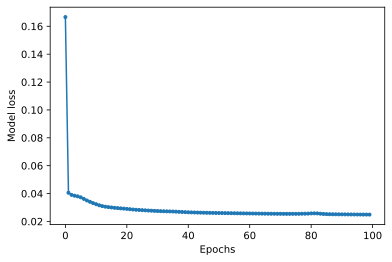

In [9]:
# train the model
losses,net = function2trainTheModel(280,8)
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

# Inspect the latent "code" of the model

torch.Size([1058, 68])
torch.Size([1058, 8])


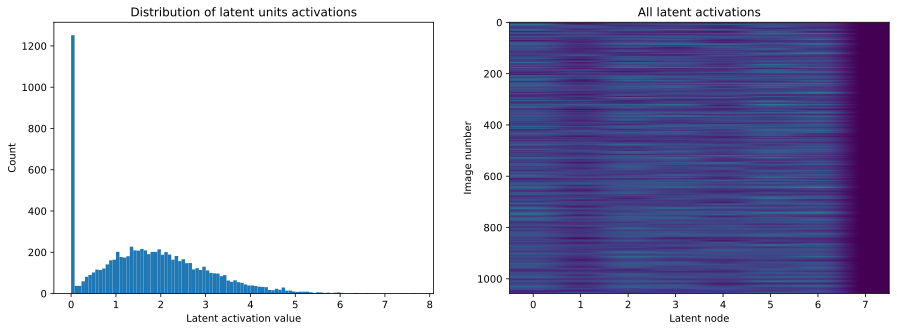

In [10]:
# output the latent layer

# push through the entire dataset
yHat,latent = net(dataT)

# print sizes
print(yHat.shape)
print(latent.shape)

# what does it look like?
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(latent.flatten().detach(),100)
ax[0].set_xlabel('Latent activation value')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of latent units activations')

ax[1].imshow(latent.detach(),aspect='auto',vmin=0,vmax=10)
ax[1].set_xlabel('Latent node')
ax[1].set_ylabel('Image number')
ax[1].set_title('All latent activations')

plt.show()

In [11]:
latent

tensor([[2.2311, 1.0658, 1.7800,  ..., 1.7262, 0.5841, 0.0000],
        [1.4887, 2.0099, 1.6415,  ..., 1.9306, 2.0170, 0.0000],
        [2.4029, 0.4744, 2.5564,  ..., 0.5303, 0.9006, 0.0000],
        ...,
        [3.8893, 1.6469, 2.3236,  ..., 2.8253, 3.0904, 0.0000],
        [1.0840, 1.5899, 1.6406,  ..., 1.6631, 2.2681, 0.0000],
        [0.5734, 4.7013, 0.0000,  ..., 3.3123, 3.1605, 0.0000]],
       grad_fn=<ReluBackward0>)

In [14]:
latent.shape[1]

8

# Explore the reduced-compressed space with PCA

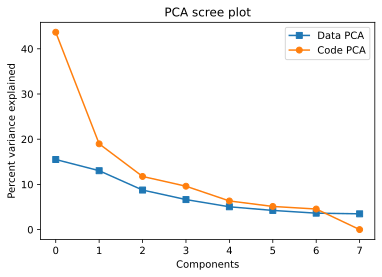

In [15]:
# compute and fit the PCA
pcaData = PCA(n_components=8).fit(data) 
pcaCode = PCA(               ).fit(latent.detach())


# plot the eigenspectra (scree plot)
plt.plot(100*pcaData.explained_variance_ratio_,'s-',label='Data PCA')
plt.plot(100*pcaCode.explained_variance_ratio_,'o-',label='Code PCA')
plt.xlabel('Components')
plt.ylabel('Percent variance explained')
plt.title('PCA scree plot')
plt.legend()
plt.show()

In [17]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(latent.detach(), xy, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset_reduct = TensorDataset(train_data,train_labels)
test_dataDataset_reduct  = TensorDataset(test_data,test_labels)


# train and test dataloaders
test_loader_reduct  = DataLoader(test_dataDataset_reduct,batch_size=test_dataDataset_reduct.tensors[0].shape[0])
train_loader_reduct = DataLoader(train_dataDataset_reduct,batch_size=32, shuffle=True, drop_last=True)

In [18]:
# create a class for the model
class ANNgc_withBNorm(nn.Module):
  def __init__(self,nHidden):
    super().__init__()

    ### input layer
    self.input = nn.Linear(8,nHidden)
    #fisrt hidden layer
    self.fc1=nn.Linear(nHidden,nHidden)
    self.bnorm1 = nn.BatchNorm1d(nHidden) # the number of units into this layer
    self.fc2    = nn.Linear(nHidden,nHidden)
    self.bnorm2 = nn.BatchNorm1d(nHidden) # the number of units into this layer
    self.fc3    = nn.Linear(nHidden,nHidden)
    self.bnorm3 = nn.BatchNorm1d(nHidden) # the number of units into this layer
    ### output layer
    self.output = nn.Linear(nHidden,2)
    # define dropout
    self.dr=0
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    #hidden layer 1
    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
    x = self.bnorm1(x) # batchnorm
    x = self.fc1(x)    # weighted combination
    x = F.relu(x)      # activation function
    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
    # hidden layer 2
    x = self.bnorm2(x) # batchnorm
    x = self.fc2(x)    # weighted combination
    x = F.relu(x)      # activation function
    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
    #hidden layer 3
    x = self.bnorm3(x) # batchnorm
    x = self.fc3(x)    # weighted combination
    x = F.relu(x)      # activation function
    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
    return self.output(x)

In [19]:
# a function that trains the model

# global parameter
numepochs = 50

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.L1Loss()
  optimizer = torch.optim.Adam(gcnet.parameters(),lr=.01)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    gcnet.train()

    # loop over training data batches
    batchLoss = []
    for X,y in train_loader_reduct :

      # forward pass and loss
      yHat = gcnet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    # test accuracy
    gcnet.eval()
    X,y = next(iter(test_loader_reduct)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = gcnet(X)
    testLoss[epochi] = lossfun(yHat,y).item()
  
  # function output
  return trainLoss,testLoss

In [20]:
gcnet = ANNgc_withBNorm(63)
trainLoss,testLoss = trainTheModel()

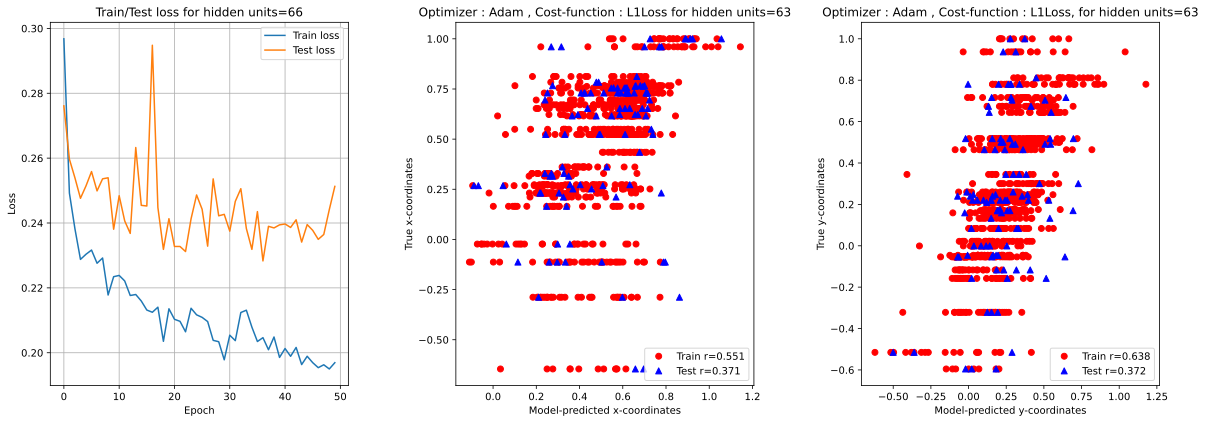

In [21]:
fig,ax = plt.subplots(1,3,figsize=(17,6))

ax[0].plot(trainLoss,label='Train loss')
ax[0].plot(testLoss,label='Test loss')
ax[0].set_title('Train/Test loss for hidden units={}'.format(66))
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


# show predictions and real values
yHatTrain = gcnet(train_data)
yHatTest  = gcnet(test_data)

ax[1].plot(yHatTrain.detach()[:,0],train_labels[:,0],'ro')
ax[1].plot(yHatTest.detach()[:,0],test_labels[:,0],'b^')
ax[1].set_xlabel('Model-predicted x-coordinates')
ax[1].set_ylabel('True x-coordinates')
ax[1].set_title('Optimizer : Adam , Cost-function : L1Loss for hidden units={}'.format(63))

ax[2].plot(yHatTrain.detach()[:,1],train_labels[:,1],'ro')
ax[2].plot(yHatTest.detach()[:,1],test_labels[:,1],'b^')
ax[2].set_xlabel('Model-predicted y-coordinates')
ax[2].set_ylabel('True y-coordinates')
ax[2].set_title('Optimizer : Adam , Cost-function : L1Loss, for hidden units={}'.format(63))
# correlations between predictions and outputs
corrTrain_x = np.corrcoef(yHatTrain.detach().T,train_labels.T)[2,0]
corrTest_x = np.corrcoef(yHatTest.detach().T, test_labels.T)[2,0]
ax[1].legend([ f'Train r={corrTrain_x:.3f}',f'Test r={corrTest_x:.3f}' ])
corrTrain_y = np.corrcoef(yHatTrain.detach().T,train_labels.T)[3,1]
corrTest_y = np.corrcoef(yHatTest.detach().T, test_labels.T)[3,1]
ax[2].legend([ f'Train r={corrTrain_y:.3f}',f'Test r={corrTest_y:.3f}' ])
plt.tight_layout()
plt.show()

In [28]:
import numpy as np
 
def MyPCA(X , num_components):
     
    #Step-1
    X_meaned = X - np.mean(X , axis = 0)
     
    #Step-2
    cov_mat = np.cov(X_meaned , rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
     
    #Step-6
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
     
    return X_reduced

In [29]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(torch.tensor(MyPCA(data[cols2zscore].values,4)).float(), xy, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset_PCA = TensorDataset(train_data,train_labels)
test_dataDataset_PCA  = TensorDataset(test_data,test_labels)


# train and test dataloaders
test_loader_PCA  = DataLoader(test_dataDataset_PCA,batch_size=test_dataDataset_PCA.tensors[0].shape[0])
train_loader_PCA = DataLoader(train_dataDataset_PCA,batch_size=32, shuffle=True, drop_last=True)

In [30]:
# create a class for the model
class ANNgc_withBNorm(nn.Module):
  def __init__(self,nHidden):
    super().__init__()

    ### input layer
    self.input = nn.Linear(4,nHidden)
    #fisrt hidden layer
    self.fc1=nn.Linear(nHidden,nHidden)
    self.bnorm1 = nn.BatchNorm1d(nHidden) # the number of units into this layer
    self.fc2    = nn.Linear(nHidden,nHidden)
    self.bnorm2 = nn.BatchNorm1d(nHidden) # the number of units into this layer
    self.fc3    = nn.Linear(nHidden,nHidden)
    self.bnorm3 = nn.BatchNorm1d(nHidden) # the number of units into this layer
    ### output layer
    self.output = nn.Linear(nHidden,2)
    # define dropout
    self.dr=0
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    #hidden layer 1
    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
    x = self.bnorm1(x) # batchnorm
    x = self.fc1(x)    # weighted combination
    x = F.relu(x)      # activation function
    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
    # hidden layer 2
    x = self.bnorm2(x) # batchnorm
    x = self.fc2(x)    # weighted combination
    x = F.relu(x)      # activation function
    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
    #hidden layer 3
    x = self.bnorm3(x) # batchnorm
    x = self.fc3(x)    # weighted combination
    x = F.relu(x)      # activation function
    x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode
    return self.output(x)

In [31]:
# a function that trains the model

# global parameter
numepochs = 50

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.L1Loss()
  optimizer = torch.optim.Adam(gcnet.parameters(),lr=.01)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    gcnet.train()

    # loop over training data batches
    batchLoss = []
    for X,y in train_loader_PCA :

      # forward pass and loss
      yHat = gcnet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    # test accuracy
    gcnet.eval()
    X,y = next(iter(test_loader_PCA)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = gcnet(X)
    testLoss[epochi] = lossfun(yHat,y).item()
  
  # function output
  return trainLoss,testLoss

In [32]:
gcnet = ANNgc_withBNorm(63)
trainLoss,testLoss = trainTheModel()

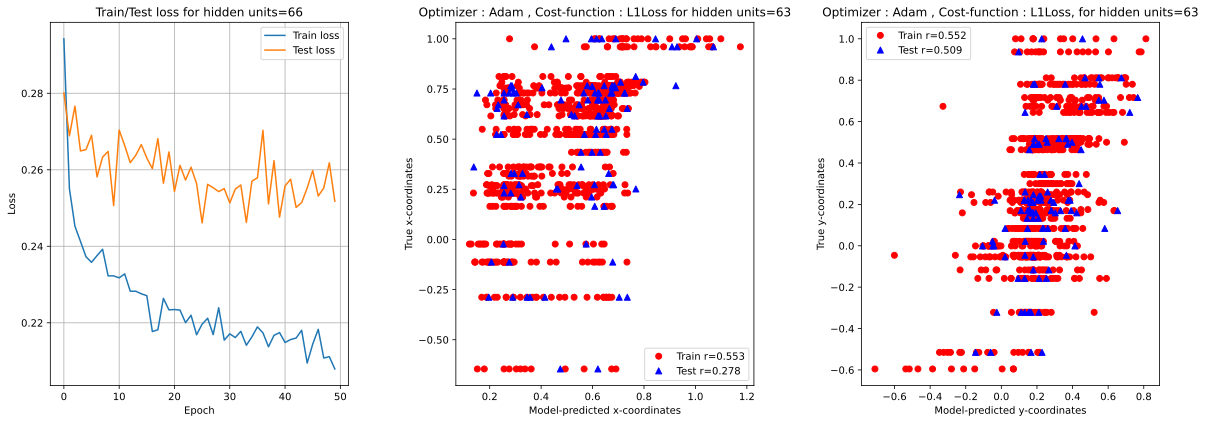

In [33]:
fig,ax = plt.subplots(1,3,figsize=(17,6))

ax[0].plot(trainLoss,label='Train loss')
ax[0].plot(testLoss,label='Test loss')
ax[0].set_title('Train/Test loss for hidden units={}'.format(66))
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


# show predictions and real values
yHatTrain = gcnet(train_data)
yHatTest  = gcnet(test_data)

ax[1].plot(yHatTrain.detach()[:,0],train_labels[:,0],'ro')
ax[1].plot(yHatTest.detach()[:,0],test_labels[:,0],'b^')
ax[1].set_xlabel('Model-predicted x-coordinates')
ax[1].set_ylabel('True x-coordinates')
ax[1].set_title('Optimizer : Adam , Cost-function : L1Loss for hidden units={}'.format(63))

ax[2].plot(yHatTrain.detach()[:,1],train_labels[:,1],'ro')
ax[2].plot(yHatTest.detach()[:,1],test_labels[:,1],'b^')
ax[2].set_xlabel('Model-predicted y-coordinates')
ax[2].set_ylabel('True y-coordinates')
ax[2].set_title('Optimizer : Adam , Cost-function : L1Loss, for hidden units={}'.format(63))
# correlations between predictions and outputs
corrTrain_x = np.corrcoef(yHatTrain.detach().T,train_labels.T)[2,0]
corrTest_x = np.corrcoef(yHatTest.detach().T, test_labels.T)[2,0]
ax[1].legend([ f'Train r={corrTrain_x:.3f}',f'Test r={corrTest_x:.3f}' ])
corrTrain_y = np.corrcoef(yHatTrain.detach().T,train_labels.T)[3,1]
corrTest_y = np.corrcoef(yHatTest.detach().T, test_labels.T)[3,1]
ax[2].legend([ f'Train r={corrTrain_y:.3f}',f'Test r={corrTest_y:.3f}' ])
plt.tight_layout()
plt.show()